In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
address = pd.read_csv('address_combined_pochta_yandex_centers.csv')
address.columns = ['address_rus','address_norm','address_post',	'address_yandex',	'address_lon','address_lat', 'SuperAdministrativeAreaName', 'AdministrativeAreaName',
       'SubAdministrativeAreaName', 'LocalityName', 'city', 'citycenter_lon',
       'citycenter_lat']
alfa = pd.read_csv('alfa-atms.csv')
sber = pd.read_csv('sber-atms-v2.csv')
sber = sber[np.isfinite(sber['lon'])]

salary = pd.read_csv('salary_v2.csv')
population = pd.read_csv('population_v2.csv')

train.shape, test.shape, address.shape, alfa.shape, sber.shape, salary.shape, population.shape

((6261, 8), (2504, 7), (6502, 13), (21043, 17), (28614, 4), (93, 2), (92, 4))

In [0]:
train['is_train'] = 1
test['is_train'] = 0

df = train.append(test)
df.sample(3)

,Unnamed: 0,address,address_rus,atm_group,id,is_train,lat,long,target
5996,5996,"D. 31, UL. KOL'COVSKAYA VORONEZH G","Кольцовская улица, 31, Воронеж, Россия, 394030",5478.0,7870.0,1,51.668473,39.193056,-0.053925
1639,1639,211-2 MIRA AV. MOSCOW,"проспект Мира, 211к2, Москва, Россия, 129226",1942.0,1532.0,1,55.845855,37.662093,0.057036
1543,1543,GAGARINA 7 PETROVSKOE,"улица Гагарина, 7, Махачкала, Республика Дагес...",496.5,8769.0,0,42.960955,47.496157,NaN


In [0]:
df.address_rus = df.apply(lambda row: row.address_rus if len(str(row.address_rus)) > 3 else row.address, axis=1)

In [0]:
df = df.merge(address, how='left', on='address_rus')

In [0]:
df['lat'] = df.apply(lambda row: row.lat if np.isfinite(row.lat) else row.address_lat , axis=1)
df['long'] = df.apply(lambda row: row.long if np.isfinite(row.long) else row.address_lon , axis=1)

In [0]:
import re

def normalize_address_rus(txt):
  
  pattern = re.compile('\d{6}')

  txt = str(txt).replace('Россия','')
  txt = txt.replace(' г ', ' ')
  txt = txt.replace(' область', ' обл')
  t2 = list()
  t = txt.split(',')
  for item in t:
    if len( item.strip() ) > 0:
      m = re.search('\d{6}', item.strip())
      try:
        m.group(0)
      except:
        t2.append(item.strip())
  addr = ', '.join(t2)


  m = re.search('\d{6}', txt)

  try:
    postal = m.group(0)
  except:
    postal = '000000'

  addr = addr + ', ' + postal

  return addr

def reverse_address(txt):
  t = str(txt).split(', ')
  list.reverse(t)
  return ', '.join(t) 

def post_code(txt):
  p = re.compile(r'\d{6}')
  res = p.findall(str(txt))

  if len(res) > 0:
    return res[0]
  else:
    return '000000'

df.address_yandex = df.address_yandex.apply(normalize_address_rus).apply(reverse_address)
df['address_norm'] = df.apply(lambda row: row.address_norm if len(str(row.address_norm)) > 3 else row.address_yandex , axis=1)
df['post_code'] = df['address_norm'].apply(post_code).astype(np.float32)
df.sample()

,Unnamed: 0,address,address_rus,atm_group,id,is_train,lat,long,target,address_norm,...,address_lon,address_lat,SuperAdministrativeAreaName,AdministrativeAreaName,SubAdministrativeAreaName,LocalityName,city,citycenter_lon,citycenter_lat,post_code
2543,2543,RADISHEVA 65/2 SARATOV,"улица имени А.Н. Радищева, 65/2, Саратов, Россия",496.5,4559.0,1,51.536991,46.039287,-0.063662,"410003, г Саратов, ул им Радищева А.Н., д 65/2",...,46.040994,51.541226,Приволжский федеральный округ,Саратовская область,городской округ Саратов,Саратов,Приволжский федеральный округ Саратовская обла...,46.034158,51.533103,410003.0


In [0]:
import math

#kremlin_lat, kremlin_lon = 55.753722, 37.620657

def dist_calc(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c
  

#df['distance_to_kremlin'] = df.apply(
#    lambda row: dist_calc(row.lat, row.long, kremlin_lat, kremlin_lon), axis=1)

df['distance_to_citycenter'] = df.apply(
    lambda row: dist_calc(row.lat, row.long, row.citycenter_lat, row.citycenter_lon), axis=1)

In [0]:
!pip install osmread

In [0]:
%%time
tagged_nodes = pd.read_pickle('osm_tagged_nodes.pickle')
print(tagged_nodes[0])

Node(id=2, version=22, changeset=0, timestamp=1504860129, uid=0, tags={'historic': 'memorial', 'image': 'https://upload.wikimedia.org/wikipedia/commons/d/d3/Pulkovo_meridian_zero-point.jpg', 'man_made': 'survey_point', 'name': 'Пулковский Меридиан', 'wikidata': 'Q4383612', 'wikipedia': 'ru:Пулковский меридиан'}, lon=30.3260539, lat=59.7718083)
CPU times: user 24.4 s, sys: 1.15 s, total: 25.5 s
Wall time: 25.5 s


In [0]:
%%time
import osmread
import time

print(len(tagged_nodes))

idx = len(tagged_nodes)

for index, row in sber.iterrows():
  if np.isfinite(row['lat']):
    for i in range(0, row['Количество']):
      idx += 1
      node = osmread.elements.Node(id=idx, version=1, changeset=0, timestamp=int(time.time()), uid=0, tags={'atm'}, lon=row['lon'], lat=row['lat'])
      tagged_nodes.append(node)
    
print(len(tagged_nodes))



4566097
4629688
CPU times: user 3.49 s, sys: 1.94 ms, total: 3.49 s
Wall time: 3.5 s


In [0]:

for index, row in alfa.iterrows():
  if np.isfinite(row['lat']):
      idx += 1
      node = osmread.elements.Node(id=idx, version=1, changeset=0, timestamp=int(time.time()), uid=0, tags={'atm'}, lon=row['lon'], lat=row['lat'])
      tagged_nodes.append(node)
    
print(len(tagged_nodes))

4650731


In [0]:
%%time

import numpy as np
from sklearn.neighbors import NearestNeighbors

# набор фильтров точек, по которым будет считаться статистика
POINT_FEATURE_FILTERS = [
    ('tagged', lambda 
     node: len(node.tags) > 0),
    ('shop', lambda node: 'shop' in node.tags),
    ('atm', lambda node: 'atm' in node.tags),
    ('subway', lambda node: 'subway' in node.tags),
    ('payment:visa', lambda node: 'payment:visa' in node.tags),
    ('parking', lambda node: 'parking' in node.tags),
    ('subway', lambda node: 'subway' in node.tags),
    ('amenity', lambda node: 'amenity' in node.tags),
    ('entrance', lambda node: 'entrance' in node.tags),
    
    
    ('cemetery', lambda node: 'cemetery' in node.tags),
    ('historic', lambda node: 'historic' in node.tags),
    ('office', lambda node: 'office' in node.tags),
    ('religion', lambda node: 'religion' in node.tags),
    ('highway', lambda node: 'highway' in node.tags),
    ('train', lambda node: 'train' in node.tags),
    ('trolleybus', lambda node: 'trolleybus' in node.tags),


]

# центры квадратов в виде матрицы
X_zone_centers = df[['lat', 'long']].fillna(0).as_matrix()

for prefix, point_filter in POINT_FEATURE_FILTERS:

    # берем подмножество точек в соответствии с фильтром
    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])

    # строим структуру данных для быстрого поиска точек
    neighbors = NearestNeighbors().fit(coords)
    
    # признак вида "количество точек в радиусе R от центра квадрата"
    for radius in [0.001, 0.0025, 0.005, 0.01]:
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

    # признак вида "расстояние до ближайших K точек"
    for n_neighbors in [2, 3, 5, 8, 13]:
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        df['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)
        # df['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = dists.max(axis=1)
        # df['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = dists.std(axis=1)

    # признак вида "расстояние до ближайшей точки"
    df['{}_min'.format(prefix)] = dists.min(axis=1)

CPU times: user 44 s, sys: 84.1 ms, total: 44.1 s
Wall time: 44 s


In [0]:
# количество банкоматов по адресу

counts = df.groupby('address')['id'].count().reset_index().rename(columns={'id':'count'})
df = df.merge(counts, how='left', on='address')

# по региону

counts_region = df.groupby('AdministrativeAreaName')['id'].count().reset_index().rename(columns={'id':'count_region'})
df = df.merge(counts_region, how='left', on='AdministrativeAreaName')

In [0]:
df['region_mean'] = df.groupby('AdministrativeAreaName')['target'].transform('mean')
# df['region_std'] = df.groupby('AdministrativeAreaName')['target'].transform('std')

In [0]:
population.head()

,region,population2018,urban2018,rural2018
0,Алтайский край,2350080,1326398,1023682
1,Амурская область,798424,537884,260540
2,Архангельская область,1155028,900962,254066
3,Астраханская область,1017514,678071,339443
4,Белгородская область,1549876,1044510,505366


In [0]:
salary.head()

,region,salary
0,Алтайский край,25656.713018
1,Амурская область,41825.467715
2,Архангельская область,46189.788230
3,Астраханская область,32219.054358
4,Белгородская область,30909.676470


In [0]:
df = df.merge(population,left_on='AdministrativeAreaName', right_on='region', how='left')
#df = df.merge(population,left_on='SuperAdministrativeAreaName', right_on='region', how='left')

df = df.merge(salary,left_on='AdministrativeAreaName', right_on='region', how='left')
#df = df.merge(salary,left_on='SuperAdministrativeAreaName', right_on='region', how='left')

In [0]:
df.sample(3)

,Unnamed: 0,address,address_rus,atm_group,id,is_train,lat,long,target,address_norm,...,trolleybus_min,count,count_region,region_mean,region_x,population2018,urban2018,rural2018,region_y,salary
2888,2888,"SVETLANOVSKAYA, 50 NOVOSIBIRSK","Светлановская улица, 50, Новосибирск, Россия, ...",3185.5,2146.0,1,55.081725,82.932871,-0.124736,"630047, г Новосибирск, ул Светлановская, д 50",...,0.108751,1,277.0,-0.021194,Новосибирская область,2788849.0,2204326.0,584523.0,Новосибирская область,34001.840778
7184,923,UL. POBEDY D.29 NOVOKUJBYSHE,"улица 50 лет Победы, 29, микрорайон Заречье, Ч...",3185.5,2301.0,0,53.236356,40.002267,NaN,"399902, Липецкая обл, г Чаплыгин, ул 50 лет По...",...,0.760351,1,64.0,-0.016877,Липецкая область,1150201.0,740253.0,409948.0,Липецкая область,30128.640749
7939,1678,"Smirnova, 9 Tomsk","улица Смирнова, 9, Томск, Россия, 634027",8083.0,3882.0,0,56.528448,84.981246,NaN,"634027, г Томск, ул Смирнова, д 9",...,0.063007,1,185.0,0.025545,Томская область,1078280.0,780804.0,297476.0,Томская область,38642.722645


In [0]:
df.drop(['region_x','region_y'], axis=1, inplace=True)

In [0]:
#df.head()

In [0]:
%%time
# Расстояния до ближайших банкоматов

R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


In [0]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from math import sin, cos, sqrt, atan2, radians

knc = KNeighborsClassifier(metric=distance)
dots = df[['lat','long']].dropna()

knc.fit(X=dots , y=np.ones(dots.shape[0]))

distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]
    
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

dots.head()

df = pd.concat([df,dots], axis=1)
df.head()

CPU times: user 18.9 s, sys: 1.82 ms, total: 18.9 s
Wall time: 18.9 s


In [0]:
rare_cities = df.city.value_counts()[(df.city.value_counts() < 20) ==True].index
df.city = df.city.apply(lambda x: 'RARE' if x in rare_cities else x)
df.city= df.city.rank().fillna(-1)

In [0]:
df['atm_group_mean'] = df.groupby('atm_group')['target'].transform('mean')
# df['atm_group_std'] = df.groupby('atm_group')['target'].transform('std')

In [0]:
df.sample()

,Unnamed: 0,address,address_rus,atm_group,id,is_train,lat,long,target,address_norm,...,distance_2,indexes_2,distance_3,indexes_3,distance_4,indexes_4,distance_5,indexes_5,mean,atm_group_mean
807,807,"D. 3, UL. MINAEVA ULYANOVSK G","улица Минаева, 3, Ульяновск, Россия, 432017",5478.0,6781.0,1,54.307531,48.38124,-0.03006,"432017, г Ульяновск, ул Минаева, д 3",...,0.70407,1379,0.70407,791,1.19454,5291,1.19454,5292,0.849518,-0.034487


In [0]:
X_train = df[df['is_train'] == 1].drop(['target','is_train', 'address','address_rus','Unnamed: 0', 'address_norm', 'address_post', 
       'address_yandex', 'address_lon', 'address_lat', 'region','SuperAdministrativeAreaName','AdministrativeAreaName','SubAdministrativeAreaName','LocalityName'], axis=1)
y_train =  df[df['is_train'] == 1]['target']

X_test = df[df['is_train'] == 0].drop(['target','is_train', 'address','address_rus','Unnamed: 0', 'address_norm', 'address_post', 
       'address_yandex', 'address_lon', 'address_lat', 'region','SuperAdministrativeAreaName','AdministrativeAreaName','SubAdministrativeAreaName','LocalityName'], axis=1)
index_test = df[df['is_train'] == 0]['Unnamed: 0']

X_train.shape, y_train.shape, X_test.shape, index_test.shape

((6261, 180), (6261,), (2504, 180), (2504,))

In [0]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

X_tra.shape, X_val.shape

((3130, 180), (3131, 180))

In [0]:
!pip install lightgbm
!pip install eli5

In [0]:
import lightgbm as lgb

clf = lgb.LGBMRegressor().fit(X_tra.fillna(0), y_tra)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf).fit(X_val.fillna(0), y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.9370 ± 0.0452,atm_group
0.0871 ± 0.0061,atm_group_mean
0.0360 ± 0.0068,region_mean
0.0092 ± 0.0021,distance_1
0.0046 ± 0.0014,id
0.0028 ± 0.0003,atm_mean_dist_k_5
0.0028 ± 0.0007,population2018
0.0021 ± 0.0010,atm_mean_dist_k_3
0.0017 ± 0.0007,distance_5
0.0013 ± 0.0009,distance_2


In [0]:
selected = eli5.explain_weights_df(perm, feature_names = X_val.columns.tolist())
features_selected = selected[selected['weight'] > 1.75 * selected['std']]['feature'].values # 1.9 - 043007
len(X_val.columns), len(features_selected), features_selected

(180,
 47,
 array(['atm_group', 'atm_group_mean', 'region_mean', 'distance_1', 'id',
        'atm_mean_dist_k_5', 'population2018', 'atm_mean_dist_k_3',
        'distance_5', 'distance_2', 'entrance_min', 'atm_points_in_0.005',
        'office_mean_dist_k_8', 'tagged_mean_dist_k_2',
        'shop_points_in_0.005', 'shop_mean_dist_k_13', 'long',
        'count_region', 'salary', 'distance_to_citycenter',
        'tagged_mean_dist_k_13', 'subway_mean_dist_k_2',
        'tagged_points_in_0.0025', 'parking_min', 'distance_4',
        'citycenter_lon', 'office_mean_dist_k_2', 'train_mean_dist_k_5',
        'payment:visa_mean_dist_k_5', 'tagged_min', 'office_mean_dist_k_3',
        'cemetery_mean_dist_k_13', 'historic_min', 'atm_points_in_0.01',
        'office_min', 'trolleybus_mean_dist_k_2', 'train_min',
        'tagged_mean_dist_k_8', 'trolleybus_mean_dist_k_5', 'religion_min',
        'rural2018', 'subway_min', 'entrance_mean_dist_k_5',
        'train_mean_dist_k_13', 'cemetery_mean_dis

In [0]:
  import lightgbm as lgb
  from sklearn.model_selection import KFold
  random_state = 42

  score = []

  params = {
      'objective' : 'rmse',
      }
  n_fold = 4
  n_estimators = 50000
  nthread = 2
  folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
  model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, nthread = nthread, n_jobs = -1)

  prediction = np.zeros(X_test.shape[0])

  for fold_n, (train_index, test_index) in enumerate(folds.split(X_train)):
      print('Fold:', fold_n)
      X_tr, X_va = X_train[features_selected].iloc[train_index], X_train[features_selected].iloc[test_index]
      y_tr, y_va = y_train.iloc[train_index], y_train.iloc[test_index]

      model.fit(X_tr, y_tr, 
              eval_set=[(X_tr, y_tr), (X_va, y_va)], eval_metric='rmse',
              verbose=100, early_stopping_rounds=50)

      y_pred = model.predict(X_test[features_selected], num_iteration=model.best_iteration_)
      score.append(model.best_score_['valid_1']['rmse'])

      prediction += y_pred

  prediction /= n_fold

  np.mean(score), np.std(score)

Fold: 0
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.0275677	valid_1's rmse: 0.0424815
Early stopping, best iteration is:
[117]	training's rmse: 0.0258703	valid_1's rmse: 0.0424448
Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.0273367	valid_1's rmse: 0.042706
Early stopping, best iteration is:
[62]	training's rmse: 0.0320188	valid_1's rmse: 0.042508
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.0271209	valid_1's rmse: 0.0440823
[200]	training's rmse: 0.0198158	valid_1's rmse: 0.0439146
Early stopping, best iteration is:
[187]	training's rmse: 0.020592	valid_1's rmse: 0.0438863
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.0274904	valid_1's rmse: 0.0433808
Early stopping, best iteration is:
[145]	training's rmse: 0.0235998	valid_1's rmse: 0.0432754


(0.04302860847252227, 0.000593369122034582)

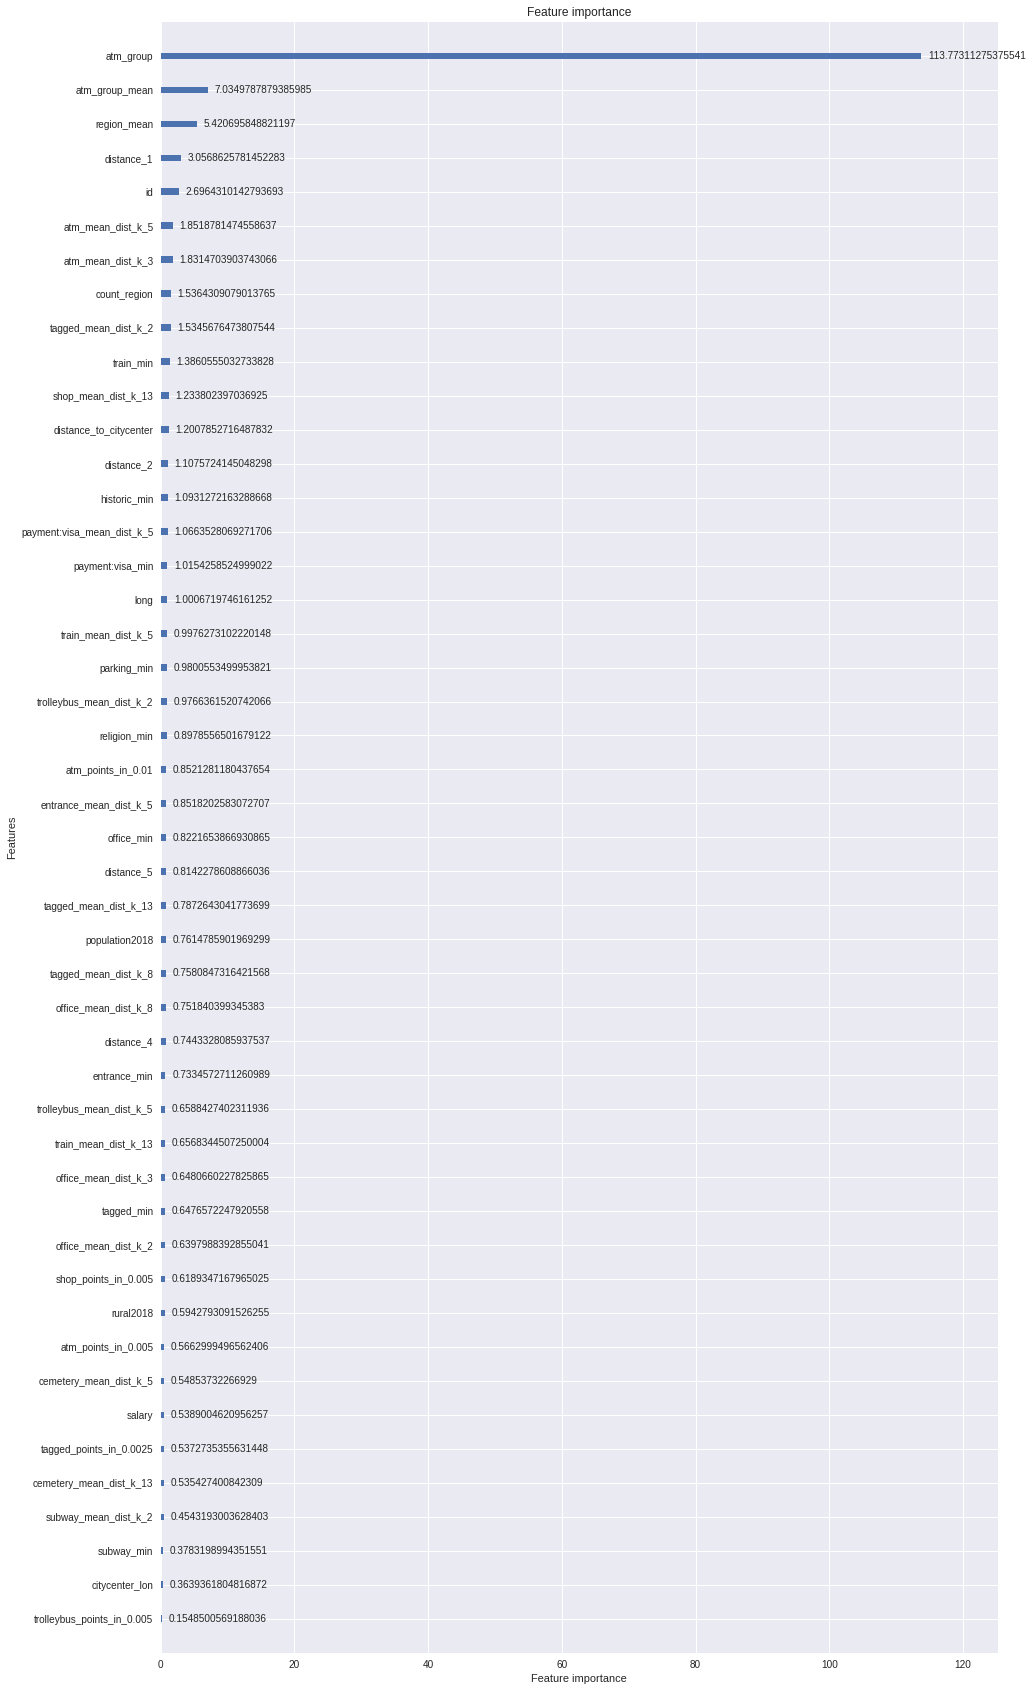

In [0]:
%matplotlib inline
lgb.plot_importance(model, importance_type='gain', figsize=(15,30));

In [0]:
len( prediction )

2504

In [0]:
sub = pd.DataFrame()
sub['0'] = index_test
sub['2'] = prediction
sub.to_csv('rosbank.csv', index=False)